In [1]:
import torch
import torchvision
import torchvision.transforms.functional as TF
import os
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class Pix2PixDataset(torch.utils.data.Dataset):
    """Custom dataset to return a pair of images"""
    def __init__(self, root, dataset, train=True, transform=None):
        split = 'train' if train else 'val'
        folder = root + '/' + dataset + '/' + dataset + '/' + split + '/'
        self.all_files = [folder + name for name in os.listdir(folder) if os.path.isfile(folder + name)]

        self.transform = transform

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, index):
        full_img = Image.open(self.all_files[index])
        split = int(full_img.size[0] / 2)
        height = full_img.size[1]
        # (left, upper, right, lower)
        img_1 = full_img.crop((0, 0, split, height))
        img_2 = full_img.crop(((split, 0, split * 2, height)))
        
        if self.transform:
            img_1, img_2 = self.transform(img_1, img_2)


        return img_1, img_2

In [3]:
# Need to define custom transforms to work on pairs of images

class PairToTensor(object):
    def __call__(self, image_1, image_2):
        return torchvision.transforms.ToTensor()(image_1), torchvision.transforms.ToTensor()(image_2)

class PairRandomCrop(object):
    def __init__(self, output_size):
        self.output_size = output_size
    
    def __call__(self, image_1, image_2):
        i, j, h, w = torchvision.transforms.RandomCrop.get_params(image_1, output_size=self.output_size)
        return TF.crop(image_1, i, j, h, w), TF.crop(image_2, i, j, h, w)

class PairCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, image_1, image_2):
        for tform in self.transforms:
            image_1, image_2 = tform(image_1, image_2)
        
        return image_1, image_2

Make sure basic functionality works

In [4]:
pix2pixdata = Pix2PixDataset('../data/pix2pix/', 'cityscapes')
img_1, img_2 = pix2pixdata[0]

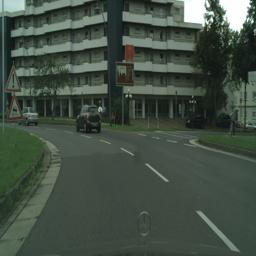

In [5]:
img_1

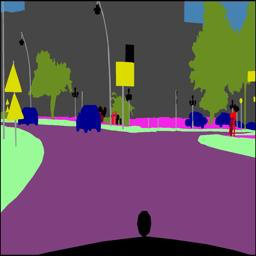

In [6]:
img_2

Try using random crop

In [7]:
pix2pixdata = Pix2PixDataset('../data/pix2pix/', 'cityscapes', transform=PairRandomCrop((100, 100)))
img_1, img_2 = pix2pixdata[0]

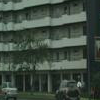

In [8]:
img_1

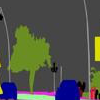

In [9]:
img_2

Convert to tensor

In [10]:
pix2pixdata = Pix2PixDataset('../data/pix2pix/', 'cityscapes', transform=PairToTensor())
img_1, img_2 = pix2pixdata[0]

In [11]:
img_1

tensor([[[0.7059, 0.6941, 0.4863,  ..., 0.1059, 0.1333, 0.0941],
         [0.7020, 0.6941, 0.4863,  ..., 0.2118, 0.1020, 0.1804],
         [0.6902, 0.6863, 0.4824,  ..., 0.1294, 0.0784, 0.1490],
         ...,
         [0.3294, 0.3294, 0.3294,  ..., 0.2157, 0.2157, 0.2157],
         [0.3216, 0.3255, 0.3255,  ..., 0.2157, 0.2157, 0.2157],
         [0.3176, 0.3216, 0.3216,  ..., 0.2157, 0.2157, 0.2157]],

        [[0.8118, 0.8000, 0.5922,  ..., 0.1686, 0.2039, 0.1647],
         [0.8078, 0.8000, 0.5922,  ..., 0.2745, 0.1725, 0.2510],
         [0.8039, 0.8000, 0.5961,  ..., 0.1922, 0.1490, 0.2196],
         ...,
         [0.4039, 0.4039, 0.4039,  ..., 0.2784, 0.2784, 0.2784],
         [0.3961, 0.4000, 0.4000,  ..., 0.2784, 0.2784, 0.2784],
         [0.3922, 0.3961, 0.3961,  ..., 0.2784, 0.2784, 0.2784]],

        [[0.7922, 0.7804, 0.5725,  ..., 0.1294, 0.1569, 0.1176],
         [0.7882, 0.7804, 0.5725,  ..., 0.2353, 0.1255, 0.2039],
         [0.7882, 0.7843, 0.5804,  ..., 0.1529, 0.1020, 0.

Custom compose

In [12]:
transform = PairCompose([
    PairRandomCrop((200, 200)),
    PairToTensor()
])
pix2pixdata = Pix2PixDataset('../data/pix2pix/', 'cityscapes', transform=transform)
img_1, img_2 = pix2pixdata[0]

Make sure works with a different dataset

In [13]:
pix2pixdata = Pix2PixDataset('../data/pix2pix/', 'facades')
img_1, img_2 = pix2pixdata[0]

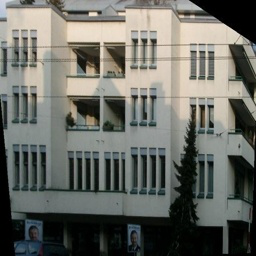

In [14]:
img_1

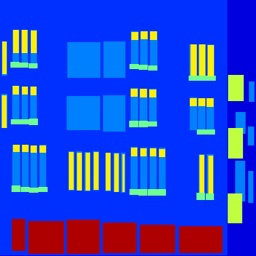

In [15]:
img_2

0 torch.Size([4, 3, 256, 256])
1 torch.Size([4, 3, 256, 256])
2 torch.Size([4, 3, 256, 256])
3 torch.Size([4, 3, 256, 256])


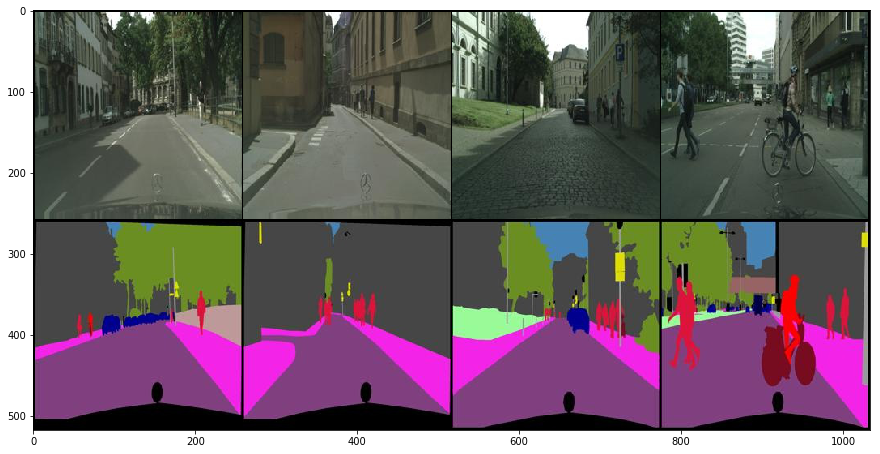

In [16]:
# Make sure it works with a dataloader
pix2pixdata = Pix2PixDataset('../data/pix2pix/', 'cityscapes', transform=PairToTensor())
dataloader = torch.utils.data.DataLoader(pix2pixdata, batch_size=4, shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    images_1, images_2 = sample_batched
    print(i_batch, images_1.size())

    # observe 4th batch and stop.
    if i_batch == 3:
        break


images_1, images_2 = sample_batched
grid = torchvision.utils.make_grid(torch.cat((images_1, images_2)), nrow=4)
plt.figure(figsize=[15, 10])
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()